In [1]:
import tensorflow as tf                  # TensorFlow

import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D, AveragePooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt

2024-03-08 11:48:05.963586: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(2115, 22, 1000)


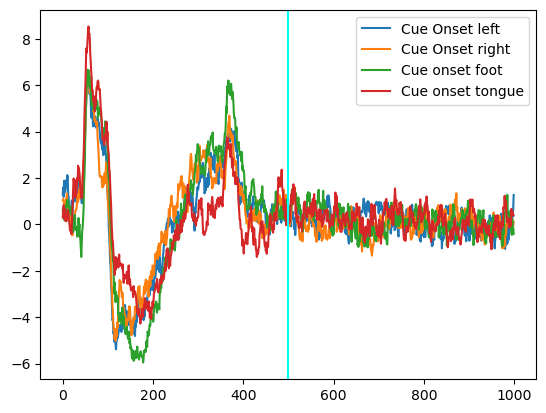

In [24]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("project/X_test.npy")
y_test = np.load("project/y_test.npy")
person_train_valid = np.load("project/person_train_valid.npy")
X_train_valid = np.load("project/X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("project/y_train_valid.npy")
person_test = np.load("project/person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])






In [4]:
# # separate subject 0 data
# person_train_valid = person_train_valid.reshape(person_train_valid.shape[0])
# subject_0_ind = np.where(person_train_valid == 0)
# X_train_valid_subject_0 = X_train_valid[subject_0_ind]
# y_train_valid_subject_0 = y_train_valid[subject_0_ind]


# person_test = person_test.reshape(person_test.shape[0])
# test_subject_0_ind = np.where(person_test == 0)
# X_test_subject_0 = X_test[test_subject_0_ind]
# y_test_subject_0 = y_test[test_subject_0_ind]


# print( X_train_valid_subject_0.shape, y_train_valid_subject_0.shape, X_test_subject_0.shape, y_test_subject_0.shape)

(237, 22, 1000) (237,) (50, 22, 1000) (50,)


In [5]:
def train_data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X):
    
    total_X = None
    
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    
    
    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)
    
    return total_X




In [6]:
# Load the TensorBoard extension
%load_ext tensorboard
# we will use the datetime to label logs
import datetime

# run this cell to clear all previous logs
!rm -rf ./logs/

# create a tensorboard callback to visualize training
tb_callback = tf.keras.callbacks.TensorBoard(log_dir="logs2/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), histogram_freq=1)

# anneals the learning rate
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 5, factor = 0.2, cooldown=5,
    min_lr=0.00001)  # reduces by a factor of 10 if validation loss doesn't improve for 10 epochs

# checkpoint saving callback
save_cb = tf.keras.callbacks.ModelCheckpoint(
    'models4/checkpoint_{epoch:02d}_{val_loss:0.2f}',   # where to save models
    monitor= 'val_loss',
    verbose = 0,
    save_best_only = False,
    save_weights_only = False,
    save_freq='epoch'   # saves every epoch
)

In [25]:
## separate subject data
person_train_valid = person_train_valid.reshape(person_train_valid.shape[0])
subject_0_ind = np.where(person_train_valid == 0)
X_train_valid_subject = X_train_valid[subject_0_ind]
y_train_valid_subject = y_train_valid[subject_0_ind]


person_test = person_test.reshape(person_test.shape[0])
test_subject_0_ind = np.where(person_test == 0)
X_test_subject = X_test[test_subject_0_ind]
y_test_subject = y_test[test_subject_0_ind]

## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(237, 50, replace=False)
ind_train = np.array(list(set(range(237)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_subject[ind_train], X_train_valid_subject[ind_valid] 
(y_train, y_valid) = y_train_valid_subject[ind_train], y_train_valid_subject[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


## Preprocessing the dataset

X_train_prep, y_train_prep = train_data_prep(x_train,y_train,2,2,True)
X_valid_prep = test_data_prep(x_valid) 
X_test_prep = test_data_prep(X_test) 
X_test_prep_subject = test_data_prep(X_test_subject) 

print('\n')
# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train_prep, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
y_test_subject = to_categorical(y_test_subject, 4)

print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)
print('Shape of test labels after categorical conversion:',y_test_subject.shape)


# Adding width of the segment to be 1
x_train = X_train_prep.reshape(X_train_prep.shape[0], X_train_prep.shape[1], X_train_prep.shape[2], 1)
x_valid = X_valid_prep.reshape(X_valid_prep.shape[0], X_valid_prep.shape[1], X_valid_prep.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
x_test_subject = X_test_prep_subject.reshape(X_test_prep_subject.shape[0], X_test_prep_subject.shape[1], X_test_prep_subject.shape[2], 1)

print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)
print('Shape of test set after adding width info:',x_test_subject.shape)

print('\n')


# Reshaping the training and validation dataset
# x_train = np.swapaxes(x_train, 1,3)
# x_train = np.swapaxes(x_train, 1,2)
# x_valid = np.swapaxes(x_valid, 1,3)
# x_valid = np.swapaxes(x_valid, 1,2)
# x_test = np.swapaxes(x_test, 1,3)
# x_test = np.swapaxes(x_test, 1,2)
# print('Shape of training set after dimension reshaping:',x_train.shape)
# print('Shape of validation set after dimension reshaping:',x_valid.shape)
# print('Shape of test set after dimension reshaping:',x_test.shape)


Shape of training set: (187, 22, 1000)
Shape of validation set: (50, 22, 1000)
Shape of training labels: (187,)
Shape of validation labels: (50,)
Shape of X after trimming: (187, 22, 500)
Shape of X after maxpooling: (187, 22, 250)
Shape of X after averaging+noise and concatenating: (374, 22, 250)
Shape of X after subsampling and concatenating: (748, 22, 250)
Shape of Y: (748,)
Shape of X after trimming: (50, 22, 500)
Shape of X after maxpooling: (50, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after trimming: (50, 22, 500)
Shape of X after maxpooling: (50, 22, 250)


Shape of training labels after categorical conversion: (748, 4)
Shape of validation labels after categorical conversion: (50, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of test labels after categorical conversion: (50, 4)
Shape of training set after adding width info: (748, 22, 250, 1)
Shape of validation set after adding width info: (

In [17]:
# Building the CNN model using sequential class
hybrid_cnn_lstm_model = Sequential()

# Conv. block 1
hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(1,64), padding='same',\
                                 input_shape=(22,250,1)))

hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(22,1), padding='valid'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Activation('elu'))
hybrid_cnn_lstm_model.add(AveragePooling2D(pool_size=(1,4), padding='same')) # Read the keras documentation
hybrid_cnn_lstm_model.add(Dropout(0.6))


# Conv. block 2
hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(1,16), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Activation('elu'))
hybrid_cnn_lstm_model.add(AveragePooling2D(pool_size=(1,8), padding='same'))
hybrid_cnn_lstm_model.add(Dropout(0.6))


# FC+LSTM layers
hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
# hybrid_cnn_lstm_model.add(Dense((40))) # FC layer with 100 units
# hybrid_cnn_lstm_model.add(Dropout(0.6))

# hybrid_cnn_lstm_model.add(Reshape((40,1))) # Reshape my output of FC layer so that it's compatible
# hybrid_cnn_lstm_model.add(LSTM(10, dropout=0.4, recurrent_dropout=0.1, input_shape=(40,1), return_sequences=False))


# Output layer with Softmax activation 
hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
hybrid_cnn_lstm_model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 22, 250, 25)       1625      
                                                                 
 batch_normalization_6 (Bat  (None, 22, 250, 25)       100       
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 1, 250, 50)        27550     
                                                                 
 batch_normalization_7 (Bat  (None, 1, 250, 50)        200       
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 1, 250, 50)        0         
                                                                 
 average_pooling2d_4 (Avera  (None, 1, 63, 50)        

In [18]:
# Model parameters
learning_rate = 1e-3
epochs = 100
hybrid_cnn_lstm_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [19]:
# Compiling the model
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), 
             callbacks=[tb_callback, lr_callback, save_cb], verbose=True)




Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 1.4646 - accuracy: 0.3489INFO:tensorflow:Assets written to: models4/checkpoint_01_1.71/assets


INFO:tensorflow:Assets written to: models4/checkpoint_01_1.71/assets


12/12 [==============================] - 5s 311ms/step - loss: 1.4646 - accuracy: 0.3489 - val_loss: 1.7091 - val_accuracy: 0.4200 - lr: 0.0010
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 1.3068 - accuracy: 0.4345INFO:tensorflow:Assets written to: models4/checkpoint_02_1.65/assets


INFO:tensorflow:Assets written to: models4/checkpoint_02_1.65/assets


12/12 [==============================] - 3s 285ms/step - loss: 1.3068 - accuracy: 0.4345 - val_loss: 1.6508 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 1.0700 - accuracy: 0.5321INFO:tensorflow:Assets written to: models4/checkpoint_03_1.77/assets


INFO:tensorflow:Assets written to: models4/checkpoint_03_1.77/assets


12/12 [==============================] - 4s 309ms/step - loss: 1.0700 - accuracy: 0.5321 - val_loss: 1.7695 - val_accuracy: 0.4200 - lr: 0.0010
Epoch 4/100
12/12 [==============================] - ETA: 0s - loss: 0.9915 - accuracy: 0.5735INFO:tensorflow:Assets written to: models4/checkpoint_04_1.26/assets


INFO:tensorflow:Assets written to: models4/checkpoint_04_1.26/assets


12/12 [==============================] - 3s 288ms/step - loss: 0.9915 - accuracy: 0.5735 - val_loss: 1.2571 - val_accuracy: 0.5400 - lr: 0.0010
Epoch 5/100
12/12 [==============================] - ETA: 0s - loss: 0.8147 - accuracy: 0.6658INFO:tensorflow:Assets written to: models4/checkpoint_05_1.38/assets


INFO:tensorflow:Assets written to: models4/checkpoint_05_1.38/assets


12/12 [==============================] - 3s 290ms/step - loss: 0.8147 - accuracy: 0.6658 - val_loss: 1.3811 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/100
12/12 [==============================] - ETA: 0s - loss: 0.7331 - accuracy: 0.7099INFO:tensorflow:Assets written to: models4/checkpoint_06_1.58/assets


INFO:tensorflow:Assets written to: models4/checkpoint_06_1.58/assets


12/12 [==============================] - 3s 294ms/step - loss: 0.7331 - accuracy: 0.7099 - val_loss: 1.5758 - val_accuracy: 0.4800 - lr: 0.0010
Epoch 7/100
12/12 [==============================] - ETA: 0s - loss: 0.6768 - accuracy: 0.7206INFO:tensorflow:Assets written to: models4/checkpoint_07_1.64/assets


INFO:tensorflow:Assets written to: models4/checkpoint_07_1.64/assets


12/12 [==============================] - 4s 309ms/step - loss: 0.6768 - accuracy: 0.7206 - val_loss: 1.6442 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 8/100
12/12 [==============================] - ETA: 0s - loss: 0.6472 - accuracy: 0.7527INFO:tensorflow:Assets written to: models4/checkpoint_08_1.26/assets


INFO:tensorflow:Assets written to: models4/checkpoint_08_1.26/assets


12/12 [==============================] - 3s 293ms/step - loss: 0.6472 - accuracy: 0.7527 - val_loss: 1.2557 - val_accuracy: 0.5600 - lr: 0.0010
Epoch 9/100
12/12 [==============================] - ETA: 0s - loss: 0.5422 - accuracy: 0.7981INFO:tensorflow:Assets written to: models4/checkpoint_09_1.36/assets


INFO:tensorflow:Assets written to: models4/checkpoint_09_1.36/assets


12/12 [==============================] - 3s 294ms/step - loss: 0.5422 - accuracy: 0.7981 - val_loss: 1.3619 - val_accuracy: 0.6200 - lr: 0.0010
Epoch 10/100
12/12 [==============================] - ETA: 0s - loss: 0.4689 - accuracy: 0.8289INFO:tensorflow:Assets written to: models4/checkpoint_10_1.56/assets


INFO:tensorflow:Assets written to: models4/checkpoint_10_1.56/assets


12/12 [==============================] - 3s 284ms/step - loss: 0.4689 - accuracy: 0.8289 - val_loss: 1.5595 - val_accuracy: 0.6200 - lr: 0.0010
Epoch 11/100
12/12 [==============================] - ETA: 0s - loss: 0.3743 - accuracy: 0.8650INFO:tensorflow:Assets written to: models4/checkpoint_11_1.54/assets


INFO:tensorflow:Assets written to: models4/checkpoint_11_1.54/assets


12/12 [==============================] - 3s 301ms/step - loss: 0.3743 - accuracy: 0.8650 - val_loss: 1.5354 - val_accuracy: 0.5800 - lr: 0.0010
Epoch 12/100
12/12 [==============================] - ETA: 0s - loss: 0.3410 - accuracy: 0.8971INFO:tensorflow:Assets written to: models4/checkpoint_12_1.73/assets


INFO:tensorflow:Assets written to: models4/checkpoint_12_1.73/assets


12/12 [==============================] - 3s 290ms/step - loss: 0.3410 - accuracy: 0.8971 - val_loss: 1.7292 - val_accuracy: 0.5400 - lr: 0.0010
Epoch 13/100
12/12 [==============================] - ETA: 0s - loss: 0.3132 - accuracy: 0.9011INFO:tensorflow:Assets written to: models4/checkpoint_13_1.33/assets


INFO:tensorflow:Assets written to: models4/checkpoint_13_1.33/assets


12/12 [==============================] - 4s 306ms/step - loss: 0.3132 - accuracy: 0.9011 - val_loss: 1.3315 - val_accuracy: 0.6600 - lr: 0.0010
Epoch 14/100
12/12 [==============================] - ETA: 0s - loss: 0.2685 - accuracy: 0.9037INFO:tensorflow:Assets written to: models4/checkpoint_14_1.51/assets


INFO:tensorflow:Assets written to: models4/checkpoint_14_1.51/assets


12/12 [==============================] - 4s 379ms/step - loss: 0.2685 - accuracy: 0.9037 - val_loss: 1.5119 - val_accuracy: 0.6800 - lr: 2.0000e-04
Epoch 15/100
12/12 [==============================] - ETA: 0s - loss: 0.2618 - accuracy: 0.9024INFO:tensorflow:Assets written to: models4/checkpoint_15_1.34/assets


INFO:tensorflow:Assets written to: models4/checkpoint_15_1.34/assets


12/12 [==============================] - 5s 482ms/step - loss: 0.2618 - accuracy: 0.9024 - val_loss: 1.3368 - val_accuracy: 0.7000 - lr: 2.0000e-04
Epoch 16/100
12/12 [==============================] - ETA: 0s - loss: 0.2203 - accuracy: 0.9291INFO:tensorflow:Assets written to: models4/checkpoint_16_1.29/assets


INFO:tensorflow:Assets written to: models4/checkpoint_16_1.29/assets


12/12 [==============================] - 6s 486ms/step - loss: 0.2203 - accuracy: 0.9291 - val_loss: 1.2944 - val_accuracy: 0.6800 - lr: 2.0000e-04
Epoch 17/100
12/12 [==============================] - ETA: 0s - loss: 0.1898 - accuracy: 0.9452INFO:tensorflow:Assets written to: models4/checkpoint_17_1.21/assets


INFO:tensorflow:Assets written to: models4/checkpoint_17_1.21/assets


12/12 [==============================] - 5s 446ms/step - loss: 0.1898 - accuracy: 0.9452 - val_loss: 1.2063 - val_accuracy: 0.7000 - lr: 2.0000e-04
Epoch 18/100
12/12 [==============================] - ETA: 0s - loss: 0.1851 - accuracy: 0.9452INFO:tensorflow:Assets written to: models4/checkpoint_18_1.27/assets


INFO:tensorflow:Assets written to: models4/checkpoint_18_1.27/assets


12/12 [==============================] - 5s 458ms/step - loss: 0.1851 - accuracy: 0.9452 - val_loss: 1.2720 - val_accuracy: 0.6800 - lr: 2.0000e-04
Epoch 19/100
12/12 [==============================] - ETA: 0s - loss: 0.1709 - accuracy: 0.9572INFO:tensorflow:Assets written to: models4/checkpoint_19_1.35/assets


INFO:tensorflow:Assets written to: models4/checkpoint_19_1.35/assets


12/12 [==============================] - 5s 460ms/step - loss: 0.1709 - accuracy: 0.9572 - val_loss: 1.3542 - val_accuracy: 0.6600 - lr: 2.0000e-04
Epoch 20/100
12/12 [==============================] - ETA: 0s - loss: 0.1650 - accuracy: 0.9626INFO:tensorflow:Assets written to: models4/checkpoint_20_1.35/assets


INFO:tensorflow:Assets written to: models4/checkpoint_20_1.35/assets


12/12 [==============================] - 6s 492ms/step - loss: 0.1650 - accuracy: 0.9626 - val_loss: 1.3490 - val_accuracy: 0.6800 - lr: 2.0000e-04
Epoch 21/100
12/12 [==============================] - ETA: 0s - loss: 0.1838 - accuracy: 0.9398INFO:tensorflow:Assets written to: models4/checkpoint_21_1.18/assets


INFO:tensorflow:Assets written to: models4/checkpoint_21_1.18/assets


12/12 [==============================] - 5s 471ms/step - loss: 0.1838 - accuracy: 0.9398 - val_loss: 1.1849 - val_accuracy: 0.7400 - lr: 2.0000e-04
Epoch 22/100
12/12 [==============================] - ETA: 0s - loss: 0.1570 - accuracy: 0.9626INFO:tensorflow:Assets written to: models4/checkpoint_22_1.21/assets


INFO:tensorflow:Assets written to: models4/checkpoint_22_1.21/assets


12/12 [==============================] - 5s 458ms/step - loss: 0.1570 - accuracy: 0.9626 - val_loss: 1.2117 - val_accuracy: 0.7000 - lr: 2.0000e-04
Epoch 23/100
12/12 [==============================] - ETA: 0s - loss: 0.1750 - accuracy: 0.9492INFO:tensorflow:Assets written to: models4/checkpoint_23_1.20/assets


INFO:tensorflow:Assets written to: models4/checkpoint_23_1.20/assets


12/12 [==============================] - 5s 472ms/step - loss: 0.1750 - accuracy: 0.9492 - val_loss: 1.2013 - val_accuracy: 0.7000 - lr: 2.0000e-04
Epoch 24/100
12/12 [==============================] - ETA: 0s - loss: 0.1630 - accuracy: 0.9612INFO:tensorflow:Assets written to: models4/checkpoint_24_1.28/assets


INFO:tensorflow:Assets written to: models4/checkpoint_24_1.28/assets


12/12 [==============================] - 6s 527ms/step - loss: 0.1630 - accuracy: 0.9612 - val_loss: 1.2763 - val_accuracy: 0.7000 - lr: 2.0000e-04
Epoch 25/100
12/12 [==============================] - ETA: 0s - loss: 0.1499 - accuracy: 0.9586INFO:tensorflow:Assets written to: models4/checkpoint_25_1.31/assets


INFO:tensorflow:Assets written to: models4/checkpoint_25_1.31/assets


12/12 [==============================] - 6s 493ms/step - loss: 0.1499 - accuracy: 0.9586 - val_loss: 1.3064 - val_accuracy: 0.6200 - lr: 2.0000e-04
Epoch 26/100
12/12 [==============================] - ETA: 0s - loss: 0.1417 - accuracy: 0.9679INFO:tensorflow:Assets written to: models4/checkpoint_26_1.22/assets


INFO:tensorflow:Assets written to: models4/checkpoint_26_1.22/assets


12/12 [==============================] - 5s 479ms/step - loss: 0.1417 - accuracy: 0.9679 - val_loss: 1.2212 - val_accuracy: 0.7000 - lr: 2.0000e-04
Epoch 27/100
12/12 [==============================] - ETA: 0s - loss: 0.1518 - accuracy: 0.9559INFO:tensorflow:Assets written to: models4/checkpoint_27_1.23/assets


INFO:tensorflow:Assets written to: models4/checkpoint_27_1.23/assets


12/12 [==============================] - 6s 508ms/step - loss: 0.1518 - accuracy: 0.9559 - val_loss: 1.2297 - val_accuracy: 0.6800 - lr: 4.0000e-05
Epoch 28/100
12/12 [==============================] - ETA: 0s - loss: 0.1210 - accuracy: 0.9733INFO:tensorflow:Assets written to: models4/checkpoint_28_1.25/assets


INFO:tensorflow:Assets written to: models4/checkpoint_28_1.25/assets


12/12 [==============================] - 7s 626ms/step - loss: 0.1210 - accuracy: 0.9733 - val_loss: 1.2516 - val_accuracy: 0.6400 - lr: 4.0000e-05
Epoch 29/100
12/12 [==============================] - ETA: 0s - loss: 0.1315 - accuracy: 0.9733INFO:tensorflow:Assets written to: models4/checkpoint_29_1.28/assets


INFO:tensorflow:Assets written to: models4/checkpoint_29_1.28/assets


12/12 [==============================] - 10s 867ms/step - loss: 0.1315 - accuracy: 0.9733 - val_loss: 1.2752 - val_accuracy: 0.6800 - lr: 4.0000e-05
Epoch 30/100
12/12 [==============================] - ETA: 0s - loss: 0.1349 - accuracy: 0.9679INFO:tensorflow:Assets written to: models4/checkpoint_30_1.29/assets


INFO:tensorflow:Assets written to: models4/checkpoint_30_1.29/assets


12/12 [==============================] - 10s 873ms/step - loss: 0.1349 - accuracy: 0.9679 - val_loss: 1.2906 - val_accuracy: 0.7000 - lr: 4.0000e-05
Epoch 31/100
12/12 [==============================] - ETA: 0s - loss: 0.1280 - accuracy: 0.9773INFO:tensorflow:Assets written to: models4/checkpoint_31_1.24/assets


INFO:tensorflow:Assets written to: models4/checkpoint_31_1.24/assets


12/12 [==============================] - 12s 1s/step - loss: 0.1280 - accuracy: 0.9773 - val_loss: 1.2373 - val_accuracy: 0.6600 - lr: 4.0000e-05
Epoch 32/100
12/12 [==============================] - ETA: 0s - loss: 0.1254 - accuracy: 0.9719INFO:tensorflow:Assets written to: models4/checkpoint_32_1.26/assets


INFO:tensorflow:Assets written to: models4/checkpoint_32_1.26/assets


12/12 [==============================] - 12s 1s/step - loss: 0.1254 - accuracy: 0.9719 - val_loss: 1.2625 - val_accuracy: 0.6800 - lr: 4.0000e-05
Epoch 33/100
12/12 [==============================] - ETA: 0s - loss: 0.1210 - accuracy: 0.9693INFO:tensorflow:Assets written to: models4/checkpoint_33_1.26/assets


INFO:tensorflow:Assets written to: models4/checkpoint_33_1.26/assets


12/12 [==============================] - 10s 886ms/step - loss: 0.1210 - accuracy: 0.9693 - val_loss: 1.2637 - val_accuracy: 0.6800 - lr: 4.0000e-05
Epoch 34/100
12/12 [==============================] - ETA: 0s - loss: 0.1321 - accuracy: 0.9679INFO:tensorflow:Assets written to: models4/checkpoint_34_1.29/assets


INFO:tensorflow:Assets written to: models4/checkpoint_34_1.29/assets


12/12 [==============================] - 10s 918ms/step - loss: 0.1321 - accuracy: 0.9679 - val_loss: 1.2903 - val_accuracy: 0.6600 - lr: 4.0000e-05
Epoch 35/100
12/12 [==============================] - ETA: 0s - loss: 0.1130 - accuracy: 0.9773INFO:tensorflow:Assets written to: models4/checkpoint_35_1.28/assets


INFO:tensorflow:Assets written to: models4/checkpoint_35_1.28/assets


12/12 [==============================] - 10s 876ms/step - loss: 0.1130 - accuracy: 0.9773 - val_loss: 1.2835 - val_accuracy: 0.6600 - lr: 4.0000e-05
Epoch 36/100
12/12 [==============================] - ETA: 0s - loss: 0.1363 - accuracy: 0.9639INFO:tensorflow:Assets written to: models4/checkpoint_36_1.27/assets


INFO:tensorflow:Assets written to: models4/checkpoint_36_1.27/assets


12/12 [==============================] - 12s 1s/step - loss: 0.1363 - accuracy: 0.9639 - val_loss: 1.2672 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 37/100
12/12 [==============================] - ETA: 0s - loss: 0.1066 - accuracy: 0.9786INFO:tensorflow:Assets written to: models4/checkpoint_37_1.27/assets


INFO:tensorflow:Assets written to: models4/checkpoint_37_1.27/assets


12/12 [==============================] - 12s 1s/step - loss: 0.1066 - accuracy: 0.9786 - val_loss: 1.2676 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 38/100
12/12 [==============================] - ETA: 0s - loss: 0.1234 - accuracy: 0.9679INFO:tensorflow:Assets written to: models4/checkpoint_38_1.27/assets


INFO:tensorflow:Assets written to: models4/checkpoint_38_1.27/assets


12/12 [==============================] - 9s 766ms/step - loss: 0.1234 - accuracy: 0.9679 - val_loss: 1.2682 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 39/100
12/12 [==============================] - ETA: 0s - loss: 0.1151 - accuracy: 0.9746INFO:tensorflow:Assets written to: models4/checkpoint_39_1.27/assets


INFO:tensorflow:Assets written to: models4/checkpoint_39_1.27/assets


12/12 [==============================] - 6s 498ms/step - loss: 0.1151 - accuracy: 0.9746 - val_loss: 1.2662 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 40/100
12/12 [==============================] - ETA: 0s - loss: 0.1108 - accuracy: 0.9759INFO:tensorflow:Assets written to: models4/checkpoint_40_1.28/assets


INFO:tensorflow:Assets written to: models4/checkpoint_40_1.28/assets


12/12 [==============================] - 6s 496ms/step - loss: 0.1108 - accuracy: 0.9759 - val_loss: 1.2764 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 41/100
12/12 [==============================] - ETA: 0s - loss: 0.1194 - accuracy: 0.9786INFO:tensorflow:Assets written to: models4/checkpoint_41_1.29/assets


INFO:tensorflow:Assets written to: models4/checkpoint_41_1.29/assets


12/12 [==============================] - 6s 516ms/step - loss: 0.1194 - accuracy: 0.9786 - val_loss: 1.2880 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 42/100
12/12 [==============================] - ETA: 0s - loss: 0.1230 - accuracy: 0.9733INFO:tensorflow:Assets written to: models4/checkpoint_42_1.29/assets


INFO:tensorflow:Assets written to: models4/checkpoint_42_1.29/assets


12/12 [==============================] - 6s 492ms/step - loss: 0.1230 - accuracy: 0.9733 - val_loss: 1.2928 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 43/100
12/12 [==============================] - ETA: 0s - loss: 0.1122 - accuracy: 0.9799INFO:tensorflow:Assets written to: models4/checkpoint_43_1.29/assets


INFO:tensorflow:Assets written to: models4/checkpoint_43_1.29/assets


12/12 [==============================] - 6s 537ms/step - loss: 0.1122 - accuracy: 0.9799 - val_loss: 1.2912 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 44/100
12/12 [==============================] - ETA: 0s - loss: 0.1146 - accuracy: 0.9733INFO:tensorflow:Assets written to: models4/checkpoint_44_1.29/assets


INFO:tensorflow:Assets written to: models4/checkpoint_44_1.29/assets


12/12 [==============================] - 6s 537ms/step - loss: 0.1146 - accuracy: 0.9733 - val_loss: 1.2912 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 45/100
12/12 [==============================] - ETA: 0s - loss: 0.1170 - accuracy: 0.9786INFO:tensorflow:Assets written to: models4/checkpoint_45_1.28/assets


INFO:tensorflow:Assets written to: models4/checkpoint_45_1.28/assets


12/12 [==============================] - 6s 558ms/step - loss: 0.1170 - accuracy: 0.9786 - val_loss: 1.2807 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 46/100
12/12 [==============================] - ETA: 0s - loss: 0.1228 - accuracy: 0.9733INFO:tensorflow:Assets written to: models4/checkpoint_46_1.28/assets


INFO:tensorflow:Assets written to: models4/checkpoint_46_1.28/assets


12/12 [==============================] - 6s 511ms/step - loss: 0.1228 - accuracy: 0.9733 - val_loss: 1.2779 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 47/100
12/12 [==============================] - ETA: 0s - loss: 0.1111 - accuracy: 0.9786INFO:tensorflow:Assets written to: models4/checkpoint_47_1.27/assets


INFO:tensorflow:Assets written to: models4/checkpoint_47_1.27/assets


12/12 [==============================] - 6s 501ms/step - loss: 0.1111 - accuracy: 0.9786 - val_loss: 1.2675 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 48/100
12/12 [==============================] - ETA: 0s - loss: 0.1252 - accuracy: 0.9706INFO:tensorflow:Assets written to: models4/checkpoint_48_1.27/assets


INFO:tensorflow:Assets written to: models4/checkpoint_48_1.27/assets


12/12 [==============================] - 6s 482ms/step - loss: 0.1252 - accuracy: 0.9706 - val_loss: 1.2685 - val_accuracy: 0.6800 - lr: 1.0000e-05
Epoch 49/100
12/12 [==============================] - ETA: 0s - loss: 0.1428 - accuracy: 0.9612INFO:tensorflow:Assets written to: models4/checkpoint_49_1.29/assets


INFO:tensorflow:Assets written to: models4/checkpoint_49_1.29/assets


12/12 [==============================] - 6s 510ms/step - loss: 0.1428 - accuracy: 0.9612 - val_loss: 1.2867 - val_accuracy: 0.6800 - lr: 1.0000e-05
Epoch 50/100
12/12 [==============================] - ETA: 0s - loss: 0.1207 - accuracy: 0.9786INFO:tensorflow:Assets written to: models4/checkpoint_50_1.29/assets


INFO:tensorflow:Assets written to: models4/checkpoint_50_1.29/assets


12/12 [==============================] - 5s 452ms/step - loss: 0.1207 - accuracy: 0.9786 - val_loss: 1.2939 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 51/100
12/12 [==============================] - ETA: 0s - loss: 0.1242 - accuracy: 0.9652INFO:tensorflow:Assets written to: models4/checkpoint_51_1.29/assets


INFO:tensorflow:Assets written to: models4/checkpoint_51_1.29/assets


12/12 [==============================] - 6s 525ms/step - loss: 0.1242 - accuracy: 0.9652 - val_loss: 1.2926 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 52/100
12/12 [==============================] - ETA: 0s - loss: 0.1192 - accuracy: 0.9693INFO:tensorflow:Assets written to: models4/checkpoint_52_1.30/assets


INFO:tensorflow:Assets written to: models4/checkpoint_52_1.30/assets


12/12 [==============================] - 6s 509ms/step - loss: 0.1192 - accuracy: 0.9693 - val_loss: 1.2989 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 53/100
12/12 [==============================] - ETA: 0s - loss: 0.1231 - accuracy: 0.9719INFO:tensorflow:Assets written to: models4/checkpoint_53_1.31/assets


INFO:tensorflow:Assets written to: models4/checkpoint_53_1.31/assets


12/12 [==============================] - 7s 596ms/step - loss: 0.1231 - accuracy: 0.9719 - val_loss: 1.3102 - val_accuracy: 0.6800 - lr: 1.0000e-05
Epoch 54/100
12/12 [==============================] - ETA: 0s - loss: 0.1208 - accuracy: 0.9639INFO:tensorflow:Assets written to: models4/checkpoint_54_1.31/assets


INFO:tensorflow:Assets written to: models4/checkpoint_54_1.31/assets


12/12 [==============================] - 6s 504ms/step - loss: 0.1208 - accuracy: 0.9639 - val_loss: 1.3108 - val_accuracy: 0.6800 - lr: 1.0000e-05
Epoch 55/100
12/12 [==============================] - ETA: 0s - loss: 0.1215 - accuracy: 0.9733INFO:tensorflow:Assets written to: models4/checkpoint_55_1.31/assets


INFO:tensorflow:Assets written to: models4/checkpoint_55_1.31/assets


12/12 [==============================] - 6s 523ms/step - loss: 0.1215 - accuracy: 0.9733 - val_loss: 1.3052 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 56/100
12/12 [==============================] - ETA: 0s - loss: 0.1106 - accuracy: 0.9773INFO:tensorflow:Assets written to: models4/checkpoint_56_1.30/assets


INFO:tensorflow:Assets written to: models4/checkpoint_56_1.30/assets


12/12 [==============================] - 6s 533ms/step - loss: 0.1106 - accuracy: 0.9773 - val_loss: 1.2959 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 57/100
12/12 [==============================] - ETA: 0s - loss: 0.1213 - accuracy: 0.9693INFO:tensorflow:Assets written to: models4/checkpoint_57_1.29/assets


INFO:tensorflow:Assets written to: models4/checkpoint_57_1.29/assets


12/12 [==============================] - 6s 513ms/step - loss: 0.1213 - accuracy: 0.9693 - val_loss: 1.2919 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 58/100
12/12 [==============================] - ETA: 0s - loss: 0.1255 - accuracy: 0.9666INFO:tensorflow:Assets written to: models4/checkpoint_58_1.29/assets


INFO:tensorflow:Assets written to: models4/checkpoint_58_1.29/assets


12/12 [==============================] - 6s 501ms/step - loss: 0.1255 - accuracy: 0.9666 - val_loss: 1.2940 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 59/100
12/12 [==============================] - ETA: 0s - loss: 0.1193 - accuracy: 0.9679INFO:tensorflow:Assets written to: models4/checkpoint_59_1.31/assets


INFO:tensorflow:Assets written to: models4/checkpoint_59_1.31/assets


12/12 [==============================] - 6s 527ms/step - loss: 0.1193 - accuracy: 0.9679 - val_loss: 1.3060 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 60/100
12/12 [==============================] - ETA: 0s - loss: 0.1253 - accuracy: 0.9693INFO:tensorflow:Assets written to: models4/checkpoint_60_1.32/assets


INFO:tensorflow:Assets written to: models4/checkpoint_60_1.32/assets


12/12 [==============================] - 4s 331ms/step - loss: 0.1253 - accuracy: 0.9693 - val_loss: 1.3153 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 61/100
12/12 [==============================] - ETA: 0s - loss: 0.1260 - accuracy: 0.9652INFO:tensorflow:Assets written to: models4/checkpoint_61_1.32/assets


INFO:tensorflow:Assets written to: models4/checkpoint_61_1.32/assets


12/12 [==============================] - 4s 317ms/step - loss: 0.1260 - accuracy: 0.9652 - val_loss: 1.3173 - val_accuracy: 0.6800 - lr: 1.0000e-05
Epoch 62/100
12/12 [==============================] - ETA: 0s - loss: 0.1391 - accuracy: 0.9545INFO:tensorflow:Assets written to: models4/checkpoint_62_1.30/assets


INFO:tensorflow:Assets written to: models4/checkpoint_62_1.30/assets


12/12 [==============================] - 3s 277ms/step - loss: 0.1391 - accuracy: 0.9545 - val_loss: 1.3029 - val_accuracy: 0.6800 - lr: 1.0000e-05
Epoch 63/100
12/12 [==============================] - ETA: 0s - loss: 0.1136 - accuracy: 0.9759INFO:tensorflow:Assets written to: models4/checkpoint_63_1.31/assets


INFO:tensorflow:Assets written to: models4/checkpoint_63_1.31/assets


12/12 [==============================] - 3s 285ms/step - loss: 0.1136 - accuracy: 0.9759 - val_loss: 1.3061 - val_accuracy: 0.6800 - lr: 1.0000e-05
Epoch 64/100
12/12 [==============================] - ETA: 0s - loss: 0.1176 - accuracy: 0.9679INFO:tensorflow:Assets written to: models4/checkpoint_64_1.30/assets


INFO:tensorflow:Assets written to: models4/checkpoint_64_1.30/assets


12/12 [==============================] - 3s 300ms/step - loss: 0.1176 - accuracy: 0.9679 - val_loss: 1.3027 - val_accuracy: 0.6800 - lr: 1.0000e-05
Epoch 65/100
12/12 [==============================] - ETA: 0s - loss: 0.1122 - accuracy: 0.9746INFO:tensorflow:Assets written to: models4/checkpoint_65_1.29/assets


INFO:tensorflow:Assets written to: models4/checkpoint_65_1.29/assets


12/12 [==============================] - 4s 304ms/step - loss: 0.1122 - accuracy: 0.9746 - val_loss: 1.2944 - val_accuracy: 0.6800 - lr: 1.0000e-05
Epoch 66/100
12/12 [==============================] - ETA: 0s - loss: 0.1190 - accuracy: 0.9666INFO:tensorflow:Assets written to: models4/checkpoint_66_1.31/assets


INFO:tensorflow:Assets written to: models4/checkpoint_66_1.31/assets


12/12 [==============================] - 4s 348ms/step - loss: 0.1190 - accuracy: 0.9666 - val_loss: 1.3082 - val_accuracy: 0.6800 - lr: 1.0000e-05
Epoch 67/100
12/12 [==============================] - ETA: 0s - loss: 0.1297 - accuracy: 0.9719INFO:tensorflow:Assets written to: models4/checkpoint_67_1.31/assets


INFO:tensorflow:Assets written to: models4/checkpoint_67_1.31/assets


12/12 [==============================] - 3s 298ms/step - loss: 0.1297 - accuracy: 0.9719 - val_loss: 1.3137 - val_accuracy: 0.6800 - lr: 1.0000e-05
Epoch 68/100
12/12 [==============================] - ETA: 0s - loss: 0.1140 - accuracy: 0.9759INFO:tensorflow:Assets written to: models4/checkpoint_68_1.32/assets


INFO:tensorflow:Assets written to: models4/checkpoint_68_1.32/assets


12/12 [==============================] - 4s 311ms/step - loss: 0.1140 - accuracy: 0.9759 - val_loss: 1.3181 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 69/100
12/12 [==============================] - ETA: 0s - loss: 0.1135 - accuracy: 0.9786INFO:tensorflow:Assets written to: models4/checkpoint_69_1.32/assets


INFO:tensorflow:Assets written to: models4/checkpoint_69_1.32/assets


12/12 [==============================] - 4s 309ms/step - loss: 0.1135 - accuracy: 0.9786 - val_loss: 1.3184 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 70/100
12/12 [==============================] - ETA: 0s - loss: 0.1222 - accuracy: 0.9706INFO:tensorflow:Assets written to: models4/checkpoint_70_1.32/assets


INFO:tensorflow:Assets written to: models4/checkpoint_70_1.32/assets


12/12 [==============================] - 4s 352ms/step - loss: 0.1222 - accuracy: 0.9706 - val_loss: 1.3183 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 71/100
12/12 [==============================] - ETA: 0s - loss: 0.1271 - accuracy: 0.9719INFO:tensorflow:Assets written to: models4/checkpoint_71_1.32/assets


INFO:tensorflow:Assets written to: models4/checkpoint_71_1.32/assets


12/12 [==============================] - 4s 350ms/step - loss: 0.1271 - accuracy: 0.9719 - val_loss: 1.3161 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 72/100
12/12 [==============================] - ETA: 0s - loss: 0.1114 - accuracy: 0.9746INFO:tensorflow:Assets written to: models4/checkpoint_72_1.31/assets


INFO:tensorflow:Assets written to: models4/checkpoint_72_1.31/assets


12/12 [==============================] - 4s 323ms/step - loss: 0.1114 - accuracy: 0.9746 - val_loss: 1.3123 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 73/100
12/12 [==============================] - ETA: 0s - loss: 0.1257 - accuracy: 0.9693INFO:tensorflow:Assets written to: models4/checkpoint_73_1.30/assets


INFO:tensorflow:Assets written to: models4/checkpoint_73_1.30/assets


12/12 [==============================] - 4s 315ms/step - loss: 0.1257 - accuracy: 0.9693 - val_loss: 1.3042 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 74/100
12/12 [==============================] - ETA: 0s - loss: 0.1108 - accuracy: 0.9773INFO:tensorflow:Assets written to: models4/checkpoint_74_1.29/assets


INFO:tensorflow:Assets written to: models4/checkpoint_74_1.29/assets


12/12 [==============================] - 4s 308ms/step - loss: 0.1108 - accuracy: 0.9773 - val_loss: 1.2944 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 75/100
12/12 [==============================] - ETA: 0s - loss: 0.1079 - accuracy: 0.9813INFO:tensorflow:Assets written to: models4/checkpoint_75_1.29/assets


INFO:tensorflow:Assets written to: models4/checkpoint_75_1.29/assets


12/12 [==============================] - 3s 267ms/step - loss: 0.1079 - accuracy: 0.9813 - val_loss: 1.2945 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 76/100
12/12 [==============================] - ETA: 0s - loss: 0.1185 - accuracy: 0.9746INFO:tensorflow:Assets written to: models4/checkpoint_76_1.30/assets


INFO:tensorflow:Assets written to: models4/checkpoint_76_1.30/assets


12/12 [==============================] - 3s 267ms/step - loss: 0.1185 - accuracy: 0.9746 - val_loss: 1.2953 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 77/100
12/12 [==============================] - ETA: 0s - loss: 0.1068 - accuracy: 0.9799INFO:tensorflow:Assets written to: models4/checkpoint_77_1.29/assets


INFO:tensorflow:Assets written to: models4/checkpoint_77_1.29/assets


12/12 [==============================] - 3s 286ms/step - loss: 0.1068 - accuracy: 0.9799 - val_loss: 1.2902 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 78/100
12/12 [==============================] - ETA: 0s - loss: 0.1034 - accuracy: 0.9733INFO:tensorflow:Assets written to: models4/checkpoint_78_1.29/assets


INFO:tensorflow:Assets written to: models4/checkpoint_78_1.29/assets


12/12 [==============================] - 4s 318ms/step - loss: 0.1034 - accuracy: 0.9733 - val_loss: 1.2865 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 79/100
12/12 [==============================] - ETA: 0s - loss: 0.1253 - accuracy: 0.9612INFO:tensorflow:Assets written to: models4/checkpoint_79_1.28/assets


INFO:tensorflow:Assets written to: models4/checkpoint_79_1.28/assets


12/12 [==============================] - 4s 342ms/step - loss: 0.1253 - accuracy: 0.9612 - val_loss: 1.2842 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 80/100
12/12 [==============================] - ETA: 0s - loss: 0.1165 - accuracy: 0.9759INFO:tensorflow:Assets written to: models4/checkpoint_80_1.29/assets


INFO:tensorflow:Assets written to: models4/checkpoint_80_1.29/assets


12/12 [==============================] - 4s 314ms/step - loss: 0.1165 - accuracy: 0.9759 - val_loss: 1.2885 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 81/100
12/12 [==============================] - ETA: 0s - loss: 0.1260 - accuracy: 0.9612INFO:tensorflow:Assets written to: models4/checkpoint_81_1.29/assets


INFO:tensorflow:Assets written to: models4/checkpoint_81_1.29/assets


12/12 [==============================] - 4s 302ms/step - loss: 0.1260 - accuracy: 0.9612 - val_loss: 1.2920 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 82/100
12/12 [==============================] - ETA: 0s - loss: 0.1094 - accuracy: 0.9773INFO:tensorflow:Assets written to: models4/checkpoint_82_1.30/assets


INFO:tensorflow:Assets written to: models4/checkpoint_82_1.30/assets


12/12 [==============================] - 4s 305ms/step - loss: 0.1094 - accuracy: 0.9773 - val_loss: 1.2981 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 83/100
12/12 [==============================] - ETA: 0s - loss: 0.1120 - accuracy: 0.9706INFO:tensorflow:Assets written to: models4/checkpoint_83_1.30/assets


INFO:tensorflow:Assets written to: models4/checkpoint_83_1.30/assets


12/12 [==============================] - 3s 278ms/step - loss: 0.1120 - accuracy: 0.9706 - val_loss: 1.2986 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 84/100
12/12 [==============================] - ETA: 0s - loss: 0.1044 - accuracy: 0.9813INFO:tensorflow:Assets written to: models4/checkpoint_84_1.30/assets


INFO:tensorflow:Assets written to: models4/checkpoint_84_1.30/assets


12/12 [==============================] - 3s 275ms/step - loss: 0.1044 - accuracy: 0.9813 - val_loss: 1.3043 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 85/100
12/12 [==============================] - ETA: 0s - loss: 0.1182 - accuracy: 0.9679INFO:tensorflow:Assets written to: models4/checkpoint_85_1.30/assets


INFO:tensorflow:Assets written to: models4/checkpoint_85_1.30/assets


12/12 [==============================] - 3s 277ms/step - loss: 0.1182 - accuracy: 0.9679 - val_loss: 1.3020 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 86/100
12/12 [==============================] - ETA: 0s - loss: 0.1157 - accuracy: 0.9666INFO:tensorflow:Assets written to: models4/checkpoint_86_1.31/assets


INFO:tensorflow:Assets written to: models4/checkpoint_86_1.31/assets


12/12 [==============================] - 4s 302ms/step - loss: 0.1157 - accuracy: 0.9666 - val_loss: 1.3098 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 87/100
12/12 [==============================] - ETA: 0s - loss: 0.1189 - accuracy: 0.9693INFO:tensorflow:Assets written to: models4/checkpoint_87_1.32/assets


INFO:tensorflow:Assets written to: models4/checkpoint_87_1.32/assets


12/12 [==============================] - 3s 266ms/step - loss: 0.1189 - accuracy: 0.9693 - val_loss: 1.3195 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 88/100
12/12 [==============================] - ETA: 0s - loss: 0.0978 - accuracy: 0.9773INFO:tensorflow:Assets written to: models4/checkpoint_88_1.33/assets


INFO:tensorflow:Assets written to: models4/checkpoint_88_1.33/assets


12/12 [==============================] - 3s 279ms/step - loss: 0.0978 - accuracy: 0.9773 - val_loss: 1.3255 - val_accuracy: 0.6800 - lr: 1.0000e-05
Epoch 89/100
12/12 [==============================] - ETA: 0s - loss: 0.1151 - accuracy: 0.9706INFO:tensorflow:Assets written to: models4/checkpoint_89_1.32/assets


INFO:tensorflow:Assets written to: models4/checkpoint_89_1.32/assets


12/12 [==============================] - 3s 289ms/step - loss: 0.1151 - accuracy: 0.9706 - val_loss: 1.3223 - val_accuracy: 0.6800 - lr: 1.0000e-05
Epoch 90/100
12/12 [==============================] - ETA: 0s - loss: 0.1101 - accuracy: 0.9706INFO:tensorflow:Assets written to: models4/checkpoint_90_1.32/assets


INFO:tensorflow:Assets written to: models4/checkpoint_90_1.32/assets


12/12 [==============================] - 3s 297ms/step - loss: 0.1101 - accuracy: 0.9706 - val_loss: 1.3241 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 91/100
12/12 [==============================] - ETA: 0s - loss: 0.0897 - accuracy: 0.9853INFO:tensorflow:Assets written to: models4/checkpoint_91_1.32/assets


INFO:tensorflow:Assets written to: models4/checkpoint_91_1.32/assets


12/12 [==============================] - 3s 296ms/step - loss: 0.0897 - accuracy: 0.9853 - val_loss: 1.3179 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 92/100
12/12 [==============================] - ETA: 0s - loss: 0.1003 - accuracy: 0.9759INFO:tensorflow:Assets written to: models4/checkpoint_92_1.31/assets


INFO:tensorflow:Assets written to: models4/checkpoint_92_1.31/assets


12/12 [==============================] - 4s 316ms/step - loss: 0.1003 - accuracy: 0.9759 - val_loss: 1.3097 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 93/100
12/12 [==============================] - ETA: 0s - loss: 0.1159 - accuracy: 0.9719INFO:tensorflow:Assets written to: models4/checkpoint_93_1.31/assets


INFO:tensorflow:Assets written to: models4/checkpoint_93_1.31/assets


12/12 [==============================] - 3s 299ms/step - loss: 0.1159 - accuracy: 0.9719 - val_loss: 1.3101 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 94/100
12/12 [==============================] - ETA: 0s - loss: 0.0922 - accuracy: 0.9853INFO:tensorflow:Assets written to: models4/checkpoint_94_1.31/assets


INFO:tensorflow:Assets written to: models4/checkpoint_94_1.31/assets


12/12 [==============================] - 4s 310ms/step - loss: 0.0922 - accuracy: 0.9853 - val_loss: 1.3126 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 95/100
12/12 [==============================] - ETA: 0s - loss: 0.1008 - accuracy: 0.9733INFO:tensorflow:Assets written to: models4/checkpoint_95_1.30/assets


INFO:tensorflow:Assets written to: models4/checkpoint_95_1.30/assets


12/12 [==============================] - 4s 307ms/step - loss: 0.1008 - accuracy: 0.9733 - val_loss: 1.3017 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 96/100
12/12 [==============================] - ETA: 0s - loss: 0.1032 - accuracy: 0.9813INFO:tensorflow:Assets written to: models4/checkpoint_96_1.31/assets


INFO:tensorflow:Assets written to: models4/checkpoint_96_1.31/assets


12/12 [==============================] - 3s 273ms/step - loss: 0.1032 - accuracy: 0.9813 - val_loss: 1.3080 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 97/100
12/12 [==============================] - ETA: 0s - loss: 0.1034 - accuracy: 0.9773INFO:tensorflow:Assets written to: models4/checkpoint_97_1.30/assets


INFO:tensorflow:Assets written to: models4/checkpoint_97_1.30/assets


12/12 [==============================] - 4s 304ms/step - loss: 0.1034 - accuracy: 0.9773 - val_loss: 1.2997 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 98/100
12/12 [==============================] - ETA: 0s - loss: 0.0970 - accuracy: 0.9813INFO:tensorflow:Assets written to: models4/checkpoint_98_1.30/assets


INFO:tensorflow:Assets written to: models4/checkpoint_98_1.30/assets


12/12 [==============================] - 3s 281ms/step - loss: 0.0970 - accuracy: 0.9813 - val_loss: 1.3025 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 99/100
12/12 [==============================] - ETA: 0s - loss: 0.1053 - accuracy: 0.9773INFO:tensorflow:Assets written to: models4/checkpoint_99_1.31/assets


INFO:tensorflow:Assets written to: models4/checkpoint_99_1.31/assets


12/12 [==============================] - 4s 304ms/step - loss: 0.1053 - accuracy: 0.9773 - val_loss: 1.3084 - val_accuracy: 0.6600 - lr: 1.0000e-05
Epoch 100/100
12/12 [==============================] - ETA: 0s - loss: 0.1073 - accuracy: 0.9759INFO:tensorflow:Assets written to: models4/checkpoint_100_1.32/assets


INFO:tensorflow:Assets written to: models4/checkpoint_100_1.32/assets


12/12 [==============================] - 3s 297ms/step - loss: 0.1073 - accuracy: 0.9759 - val_loss: 1.3214 - val_accuracy: 0.6600 - lr: 1.0000e-05


In [ ]:
# tensorboard --logdir logs2

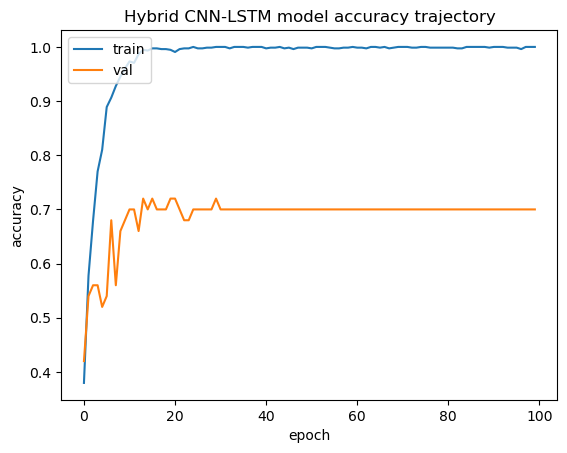

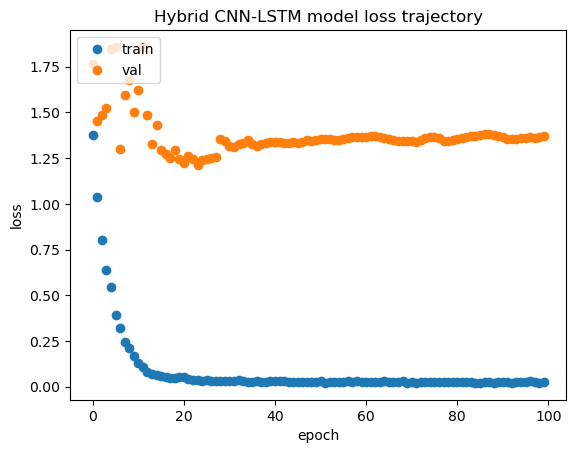

In [16]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_results.history['val_accuracy'])
plt.title('Hybrid CNN-LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN-LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [26]:
## Testing the hybrid CNN-LSTM model

hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test_subject, y_test_subject, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model on subject test:',hybrid_cnn_lstm_score[1])


hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model on all subject test:',hybrid_cnn_lstm_score[1])


Test accuracy of the hybrid CNN-LSTM model on subject test: 0.5199999809265137
Test accuracy of the hybrid CNN-LSTM model on all subject test: 0.3905192017555237
